## personalizeで使用するデータの作成
このノートブックを初めて使用する際はこちらからスタートします。

In [ ]:
! aws s3 cp s3://20190604-obc/personalize/ratings_mod.csv ./
! aws s3 cp s3://20190604-obc/personalize/movies.csv ./

MovieLensのデータを加工してpersonalizeで使いやすいようにします。

In [ ]:
%matplotlib inline

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

rating_data_org = pd.read_csv('ratings_org.csv', delimiter=',')
movie_data = pd.read_csv('movies.csv', delimiter=',')

rating_like = rating_data_org[rating_data_org.rating>=3].drop('rating', axis=1).rename(columns={'userId': 'USER_ID', 'movieId': 'ITEM_ID', 'timestamp': 'TIMESTAMP'})
rating_like.to_csv('ratings_mod.csv',  index=False)

rating_like.head()

## ジャンルのヒストグラム作成用関数の定義

In [17]:
def make_histgram(data, key):

    genre_list = []
    for g in data:
        gs = g.split('|')
        for s in gs:
            genre_list.append(s)

    genre_array = np.array(genre_list)

    counter = Counter(genre_array)
    hist_list = []
    for word, cnt in counter.most_common():
        hist_list.append([word, cnt])

    hist_ = pd.DataFrame(hist_list, columns=[key, 'COUNT'])
    hist = hist_.set_index(key)
    
    return hist

## データの内容の確認

### 全データのジャンルの分布
まずは登録されている映画全体のジャンルの傾向を見てみましょう。トップ3はドラマ，コメディ，スリラーとなっています。

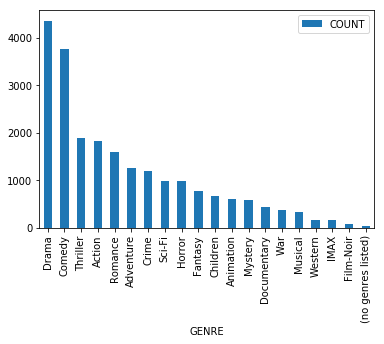

In [18]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter

movie_data = pd.read_csv('movies.csv', delimiter=',')

genre_whole = movie_data['GENRE']
hist_whole = make_histgram(genre_whole, 'GENRE')
hist_whole.plot(kind="bar")
plt.show()

### user_id=100の好きなジャンル
このサンプルではuser_id=10の人へのリコメンドをしてみましょう。<br>
user_id=100の人が見た映画のジャンルをヒストグラムで表示します。この方はどうやらロマンス，コメディ，ドラマが好きなようです。

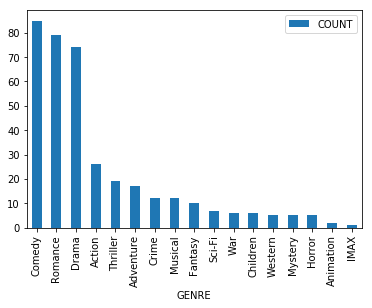

,USER_ID,ITEM_ID,TIMESTAMP,TITLE,GENRE
143,100,6785,1100184338,Seven Brides for Seven Brothers (1954),Comedy|Musical|Romance|Western
144,100,6873,1100186781,Intolerable Cruelty (2003),Comedy|Romance
145,100,7149,1100184159,Something's Gotta Give (2003),Comedy|Drama|Romance
146,100,8529,1100184289,"Terminal, The (2004)",Comedy|Drama|Romance
147,100,8636,1100186770,Spider-Man 2 (2004),Action|Adventure|Sci-Fi|IMAX


In [77]:
user_id = 100

rating_data = pd.read_csv('ratings.csv', delimiter=',')
rating_data_user = rating_data[rating_data.USER_ID==user_id]
merge_data = pd.merge(rating_data_user, movie_data, on='ITEM_ID')
genre_user = merge_data[merge_data.USER_ID==user_id]['GENRE']

hist = make_histgram(genre_user, 'GENRE')
hist.plot(kind="bar")
plt.show()

(merge_data.tail())

## データセットグループの作成

In [1]:
import boto3

personalize = boto3.client('personalize')

response = personalize.create_dataset_group(name = 'movie-recommend')
dsg_arn = response['datasetGroupArn']

description = personalize.describe_dataset_group(datasetGroupArn = dsg_arn)['datasetGroup']

print('Name: ' + description['name'])
print('ARN: ' + description['datasetGroupArn'])
print('Status: ' + description['status'])

Name: movie-recommend
ARN: arn:aws:personalize:us-east-1:420964472730:dataset-group/movie-recommend
Status: CREATE PENDING


In [4]:
personalize.list_schemas()

{'schemas': [{'name': 'test-event-schema',
   'schemaArn': 'arn:aws:personalize:us-east-1:420964472730:schema/test-event-schema',
   'creationDateTime': datetime.datetime(2019, 6, 30, 15, 7, 9, 734000, tzinfo=tzlocal()),
   'lastUpdatedDateTime': datetime.datetime(2019, 6, 30, 15, 7, 9, 734000, tzinfo=tzlocal())},
  {'name': 'test-schema',
   'schemaArn': 'arn:aws:personalize:us-east-1:420964472730:schema/test-schema',
   'creationDateTime': datetime.datetime(2019, 6, 29, 17, 50, 2, 772000, tzinfo=tzlocal()),
   'lastUpdatedDateTime': datetime.datetime(2019, 6, 29, 17, 50, 2, 772000, tzinfo=tzlocal())},
  {'name': 'test-schema-item',
   'schemaArn': 'arn:aws:personalize:us-east-1:420964472730:schema/test-schema-item',
   'creationDateTime': datetime.datetime(2019, 6, 29, 18, 4, 39, 716000, tzinfo=tzlocal()),
   'lastUpdatedDateTime': datetime.datetime(2019, 6, 29, 18, 4, 39, 716000, tzinfo=tzlocal())},
  {'name': 'test-schema-user',
   'schemaArn': 'arn:aws:personalize:us-east-1:420964

## データセットの作成

In [5]:
import boto3

personalize = boto3.client('personalize')

response = personalize.create_dataset(
    name = 'movie-recommend',
    schemaArn = 'arn:aws:personalize:us-east-1:420964472730:schema/test-schema',
    datasetGroupArn = 'arn:aws:personalize:us-east-1:420964472730:dataset-group/movie-recommend',
    datasetType = 'Interactions')

print ('Dataset Arn: ' + response['datasetArn'])

Dataset Arn: arn:aws:personalize:us-east-1:420964472730:dataset/movie-recommend/INTERACTIONS


## データセットのインポート

In [7]:
import boto3

personalize = boto3.client('personalize')

response = personalize.create_dataset_import_job(
    jobName = 'import-job1',
    datasetArn = 'arn:aws:personalize:us-east-1:420964472730:dataset/movie-recommend/INTERACTIONS',
    dataSource = {'dataLocation':'s3://20190604-obc/personalize/pre/ratings.csv'},
    roleArn = 'arn:aws:iam::420964472730:role/service-role/AmazonPersonalize-ExecutionRole-1561798696304')

dsij_arn = response['datasetImportJobArn']

print ('Dataset Import Job arn: ' + dsij_arn)

description = personalize.describe_dataset_import_job(
    datasetImportJobArn = dsij_arn)['datasetImportJob']

print('Name: ' + description['jobName'])
print('ARN: ' + description['datasetImportJobArn'])
print('Status: ' + description['status'])

Dataset Import Job arn: arn:aws:personalize:us-east-1:420964472730:dataset-import-job/import-job1
Name: import-job1
ARN: arn:aws:personalize:us-east-1:420964472730:dataset-import-job/import-job1
Status: CREATE PENDING


## ソリューションの作成

In [10]:
import boto3

personalize = boto3.client('personalize')

print ('Creating solution')
response = personalize.create_solution(
    name = "solution-movie-recommend",
    datasetGroupArn = "arn:aws:personalize:us-east-1:420964472730:dataset-group/movie-recommend",
    performAutoML = True)

# Get the solution ARN.
solution_arn = response['solutionArn']
print('Solution ARN: ' + solution_arn)

# Use the solution ARN to get the solution status.
solution_description = personalize.describe_solution(solutionArn = solution_arn)['solution']
print('Solution status: ' + solution_description['status'])

# Use the solution ARN to create a solution version.
print ('Creating solution version')
response = personalize.create_solution_version(solutionArn = solution_arn)
solution_version_arn = response['solutionVersionArn']
print('Solution version ARN: ' + solution_version_arn)

# Use the solution version ARN to get the solution version status.
solution_version_description = personalize.describe_solution_version(
    solutionVersionArn = solution_version_arn)['solutionVersion']
print('Solution version status: ' + solution_version_description['status'])

Creating solution
Solution ARN: arn:aws:personalize:us-east-1:420964472730:solution/solution-movie-recommend
Solution status: ACTIVE
Creating solution version
Solution version ARN: arn:aws:personalize:us-east-1:420964472730:solution/solution-movie-recommend/b6e32704
Solution version status: CREATE PENDING


## キャンペーンの作成

In [12]:
import boto3

personalize = boto3.client('personalize')

response = personalize.create_campaign(
    name = 'campaign-movie2',
    solutionVersionArn = 'arn:aws:personalize:us-east-1:420964472730:solution/solution-movie-recommend/b6e32704',
    minProvisionedTPS = 10)

arn = response['campaignArn']

description = personalize.describe_campaign(campaignArn = arn)['campaign']
print('Name: ' + description['name'])
print('ARN: ' + description['campaignArn'])
print('Status: ' + description['status'])

Name: campaign-movie2
ARN: arn:aws:personalize:us-east-1:420964472730:campaign/campaign-movie2
Status: CREATE PENDING


## APIを使ってリコメンド実行

In [84]:
import boto3

personalizeRt = boto3.client('personalize-runtime')

response = personalizeRt.get_recommendations(
    campaignArn = "arn:aws:personalize:us-east-1:420964472730:campaign/campaign-movie2",
    userId = str(user_id))



おすすめされた映画のトップ5つのジャンルトップを見てみると，コメディ，ドラマ，ロマンスとなっています。<br>
はじめに確認した通りuser_id=100の方はロマンス，コメディ，ドラマが好きな方だったので，嗜好に合ったリコメンドができていると言えます。

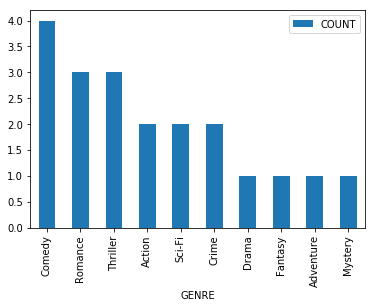

,ITEM_ID,TITLE,GENRE
RANK,,,
1,357,Four Weddings and a Funeral (1994),Comedy|Romance
2,3108,"Fisher King, The (1991)",Comedy|Drama|Fantasy|Romance
3,1544,"Lost World: Jurassic Park, The (1997)",Action|Adventure|Sci-Fi|Thriller
4,21,Get Shorty (1995),Comedy|Crime|Thriller
5,5445,Minority Report (2002),Action|Crime|Mystery|Sci-Fi|Thriller


In [85]:
item_list = [int(i['itemId']) for i in response['itemList']]

results = []
for i,d in enumerate(item_list):
    results.append([i+1, *movie_data[movie_data.ITEM_ID==d].values[0]])

res_df = pd.DataFrame(results, columns=['RANK', 'ITEM_ID', 'TITLE', 'GENRE']).set_index('RANK')

hist_df = res_df[:6]
hist_pred = make_histgram(hist_df['GENRE'], 'GENRE')
hist_pred.plot(kind="bar")
plt.show()

res_df.head()